INPUTS
- `sset.PATH_CIAM_COASTLINES`
- `sset.PATH_GADM_ADM1_VORONOI`

OUTPUTS
- `sset.PATH_CIAM_COASTLINES_BY_ISO`

In [1]:
import geopandas as gpd
import numpy as np
import pygeos

from sliiders import settings as sset
from sliiders import spatial as pv

pv.filter_spatial_warnings()

In [2]:
def get_simple_coastlines():
    """Read in coastlines and break them up into their component (2-point) line segments"""
    coastlines = gpd.read_file(sset.PATH_CIAM_COASTLINES)

    coords, linestring_ix = pygeos.get_coordinates(
        pygeos.from_shapely(coastlines["geometry"]), return_index=True
    )

    start, end = coords[:-1], coords[1:]

    tiny_segs = pygeos.linestrings(
        np.stack((start[:, 0], end[:, 0]), axis=1),
        np.stack((start[:, 1], end[:, 1]), axis=1),
    )

    tiny_segs = tiny_segs[linestring_ix[:-1] == linestring_ix[1:]]

    linestring_ix = linestring_ix[:-1][linestring_ix[:-1] == linestring_ix[1:]]

    line_id = np.take(coastlines["line_id"].to_numpy(), linestring_ix)

    coastlines = gpd.GeoDataFrame(
        {"line_id": line_id}, geometry=pygeos.to_shapely(tiny_segs)
    )

    return coastlines


def join_coastlines_to_isos(coastlines):
    # Use adm1 regions as a proxy for countries. It's faster because the regions are more
    # narrowly located than the countries in the STRtree, but could instead subdivide countries
    adm1 = gpd.read_parquet(sset.PATH_GADM_ADM1_VORONOI)

    tree = pygeos.STRtree(pygeos.from_shapely(adm1["geometry"]))

    coastal_ix, adm1_ix = tree.query_bulk(
        pygeos.from_shapely(coastlines["geometry"]), "intersects"
    )

    coastal_geo = np.take(coastlines["geometry"].to_numpy(), coastal_ix)
    adm1_geo = np.take(adm1["geometry"].to_numpy(), adm1_ix)

    joined = gpd.GeoDataFrame(
        {
            "line_id": np.take(coastlines["line_id"].to_numpy(), coastal_ix),
            "adm1_geo": gpd.GeoSeries(adm1_geo),
            "ISO": np.take(adm1["ISO"].to_numpy(), adm1_ix),
        },
        geometry=coastal_geo,
    )

    return joined

### Get coastal components (line segments)

In [3]:
coastlines = get_simple_coastlines()

### Get all matches between coastal components and ADM1 regions

In [4]:
coastlines = join_coastlines_to_isos(coastlines)

#### Clip matched coastal components to the `adm1` regions they are matched with

In [5]:
coastlines["geometry"] = coastlines["geometry"].intersection(coastlines["adm1_geo"])
coastlines = coastlines.drop(columns=["adm1_geo"])
coastlines = coastlines[~coastlines["geometry"].is_empty].reset_index(drop=True)

#### Merge LineStrings where possible

In [6]:
coastlines["geometry"] = coastlines["geometry"].apply(pv.grab_lines)

### Save

In [10]:
coastlines.to_parquet(sset.PATH_CIAM_COASTLINES_BY_ISO, index=False)

### Check output

<AxesSubplot:>

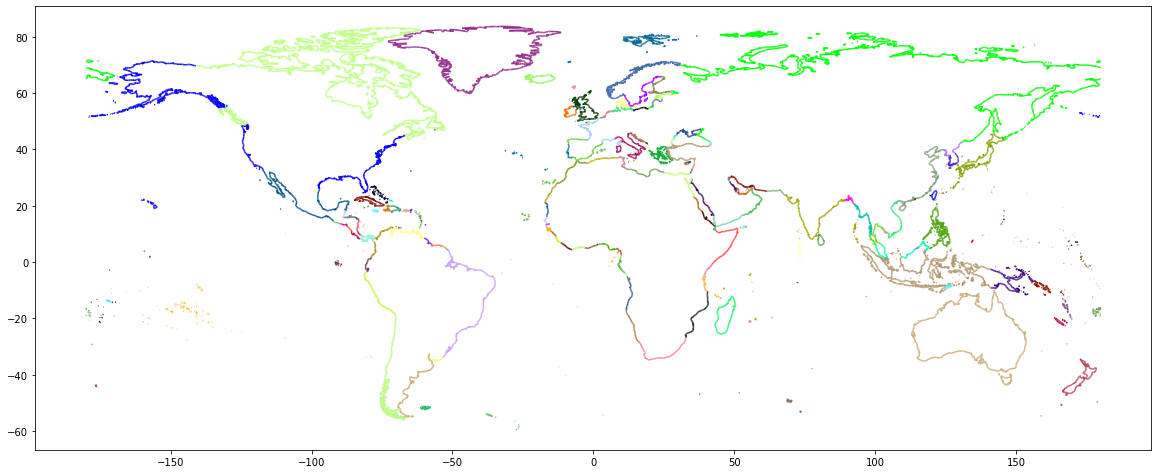

In [19]:
coastlines["color"] = pv.add_rand_color(coastlines, col="ISO")

coastlines.plot(color=coastlines["color"], figsize=(20, 20))